In [1]:
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
import cv2
from matplotlib import pyplot as plt
import os
import platform

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

## Train

In [2]:
setup_logger()

# Number of Tangram shapes
TANGRAM_NUM = 7

In [3]:
# Register the datasets
register_coco_instances("tangram_train", {}, "dataset/train.json", "dataset")
register_coco_instances("tangram_test", {}, "dataset/test.json", "dataset")

tangram_train_metadata = MetadataCatalog.get("tangram_train")
dataset_dicts = DatasetCatalog.get("tangram_train")

[12/22 12:53:51 d2.data.datasets.coco]: Loaded 80 images in COCO format from dataset/train.json


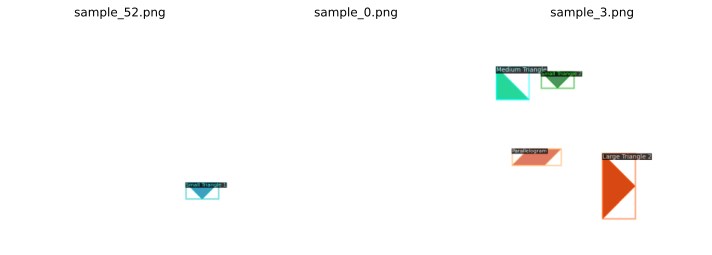

In [4]:
import random
from detectron2.utils.visualizer import Visualizer

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Visualize the dataset
for ax, d in zip(axes, random.sample(dataset_dicts, 3)):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=tangram_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    ax.imshow(vis.get_image()[:, :, ::-1])
    ax.set_title(d["file_name"].split('/')[-1])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Configure the model
cfg = get_cfg()

# Load the base configuration for Mask R-CNN
cfg.merge_from_file("configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# Dataset settings
cfg.DATASETS.TRAIN = ("tangram_train",)
cfg.DATASETS.TEST = ("tangram_test",)

# DataLoader settings
cfg.DATALOADER.NUM_WORKERS = 2

# Pre-trained weights from COCO (detectron2's model zoo)
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"

# Solver settings
cfg.SOLVER.IMS_PER_BATCH = 2  # Adjust based on GPU memory
cfg.SOLVER.BASE_LR = 0.001  # Learning rate
cfg.SOLVER.MAX_ITER = 100  # Number of iterations
# ROI head settings
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = TANGRAM_NUM  # Ensure this matches dataset categories
# Platform-specific settings
if platform.system() == "Windows":
    cfg.MODEL.DEVICE = "cuda"  # Use CUDA for GPU acceleration on Windows
# elif platform.system() == "Darwin":
#     cfg.MODEL.DEVICE = "mps"  # Use Metal Performance Shaders on macOS
else:
    cfg.MODEL.DEVICE = "cpu"  # Default to CPU for other platforms
# Create output directory
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
print("Training complete")

[12/22 12:53:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (28, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (28,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (7, 256, 1, 1) 

[12/22 12:53:52 d2.engine.train_loop]: Starting training from iteration 0


/opt/homebrew/Caskroom/miniconda/base/envs/tangram/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/22 12:55:27 d2.utils.events]:  eta: 0:06:17  iter: 19  total_loss: 3.154  loss_cls: 1.525  loss_box_reg: 0.9091  loss_mask: 0.6815  loss_rpn_cls: 0.02777  loss_rpn_loc: 0.01029    time: 4.6332  last_time: 4.8022  data_time: 0.0797  last_data_time: 0.0011   lr: 0.00019081  
[12/22 12:57:08 d2.utils.events]:  eta: 0:04:53  iter: 39  total_loss: 2.247  loss_cls: 0.7238  loss_box_reg: 0.9386  loss_mask: 0.5392  loss_rpn_cls: 0.0005719  loss_rpn_loc: 0.008317    time: 4.8571  last_time: 4.3219  data_time: 0.0013  last_data_time: 0.0014   lr: 0.00039061  
[12/22 12:59:01 d2.utils.events]:  eta: 0:03:23  iter: 59  total_loss: 1.82  loss_cls: 0.6331  loss_box_reg: 0.8927  loss_mask: 0.2657  loss_rpn_cls: 0.0004519  loss_rpn_loc: 0.008733    time: 5.1213  last_time: 5.5127  data_time: 0.0015  last_data_time: 0.0013   lr: 0.00059041  
[12/22 13:01:54 d2.utils.events]:  eta: 0:01:45  iter: 79  total_loss: 1.421  loss_cls: 0.551  loss_box_reg: 0.7424  loss_mask: 0.08631  loss_rpn_cls: 4.172e-0

In [6]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Perform inference on an image

In [7]:
# Step 1: Configure the model for inference
cfg = get_cfg()
cfg.merge_from_file("configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# Set the weights to your trained model's final weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for predictions
cfg.MODEL.ROI_HEADS.NUM_CLASSES = TANGRAM_NUM  # Ensure this matches your training classes

# Select the device (GPU/CPU) for inference
if platform.system() == "Windows":
    cfg.MODEL.DEVICE = "cuda"
else:
    cfg.MODEL.DEVICE = "cpu"

# Create a predictor
predictor = DefaultPredictor(cfg)


[12/22 13:04:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/opt/homebrew/Caskroom/miniconda/base/envs/tangram/lib/python3.11/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.l

{'instances': Instances(num_instances=5, image_height=1024, image_width=1024, fields=[pred_boxes: Boxes(tensor([[215.0157, 205.7384, 352.1980, 364.9667],
        [442.6977, 285.6850, 506.2305, 502.8460],
        [515.7072, 721.0018, 653.9955, 871.3160],
        [563.5390, 173.6369, 630.3700, 315.8378],
        [244.7733, 575.1865, 309.5752, 708.5776]])), scores: tensor([0.9512, 0.8414, 0.7033, 0.5875, 0.5662]), pred_classes: tensor([5, 6, 2, 6, 6]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

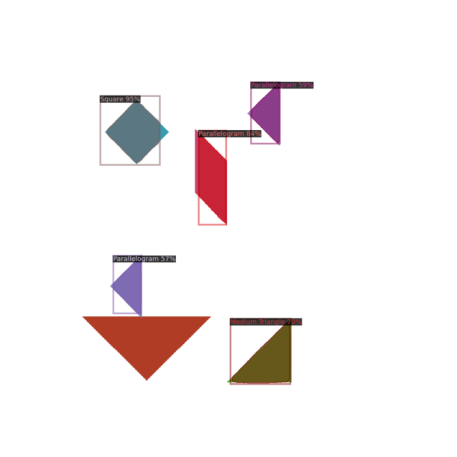

In [10]:
# Load an image for testing
image_path = "dataset/images/sample_2.png"  # Replace with the path to your test image
image = cv2.imread(image_path)

# Perform inference
outputs = predictor(image)

# The outputs contain predictions for instances
# Example: outputs["instances"].pred_classes, outputs["instances"].pred_boxes
print(outputs)

# Step 3: Visualize the results
metadata = MetadataCatalog.get("tangram_train")  # Replace with your dataset name
visualizer = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.2)
vis_output = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the result
plt.figure(figsize=(12, 8))
plt.imshow(vis_output.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()